# Combine Numeric and Categorical Features

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import pandas as pd

In [4]:
import numpy as np

def get_rand_idxs(start, end, size, seed=1234):
    np.random.seed(seed)
    return np.random.randint(start, end, size)

In [5]:
def run_prediction(X, y, Xt, yt, model):
    if len(y.shape) == 1:
        y = y.reshape(-1, 1)
    if len(yt.shape) == 1:
        yt = yt.reshape(-1, 1)
    
    res = {'train': {}, 'test': {}}
    
    model.fit(X, y)
    
    train_pred = model.predict(X)
    res['train']['pred'] = train_pred
    
    test_pred = model.predict(Xt)
    res['test']['pred'] = test_pred
    
    
    for name, tup in zip(['train', 'test'], [(y, train_pred), (yt, test_pred)]):
        act, prd = tup[0].ravel(), tup[1].ravel()
        print 'Results for %s' % name
        
        mserr = mean_squared_error(act, prd)
        res[name]['mse'] = mserr
        print '%s Mean Squared Error: %.4f' % (name, mserr)
        
        rsq_score = r2_score(act, prd)
        res[name]['r2'] = rsq_score
        print '%s R-Squared: %.4f' % (name, rsq_score)
        
        plt.scatter(act, prd, alpha=0.5)
        plt.title(name+': predictions vs. actual')
        plt.show()
        plt.scatter(act, act-prd, alpha=0.5)
        plt.title(name+': residuals vs. actual')
        plt.show()
        plt.hist(act-prd, alpha=0.5)
        plt.title(name+': residuals histogram')
        plt.show()
    
    return res

# Load Numeric Data

In [6]:
# We have to use float for now because int cannot accept NaN
num_data = pd.read_csv('./data/numeric_features.csv', low_memory=False, dtype=float)
print num_data.columns
num_data = num_data.drop('Unnamed: 0', axis=1)
num_data['id'] = num_data['id'].astype(int).astype("category")

num_data = num_data.drop('host_total_listings_count', axis=1)

print num_data.shape
num_data.sample()

Index([u'Unnamed: 0', u'id', u'bathrooms', u'bedrooms', u'beds',
       u'cleaning_fee', u'guests_included', u'host_listings_count',
       u'host_total_listings_count', u'host_acceptance_rate',
       u'host_response_rate'],
      dtype='object')
(243721, 9)


,id,bathrooms,bedrooms,beds,cleaning_fee,guests_included,host_listings_count,host_acceptance_rate,host_response_rate
92131,88172,1.0,1.0,1.0,25.0,1.0,1.0,NaN,NaN


# Load Bool Data

In [7]:
bool_data = pd.read_csv('./data/bool_features.csv', low_memory=False, dtype=int)
print bool_data.columns

bool_data = bool_data.drop('Unnamed: 0', axis=1)
bool_data['id'] = bool_data['id'].astype(int).astype("category")

bool_data.host_has_profile_pic = bool_data.host_has_profile_pic.astype(bool)
bool_data.host_identity_verified = bool_data.host_identity_verified.astype(bool)

print bool_data.shape


Index([u'Unnamed: 0', u'id', u'host_has_profile_pic',
       u'host_identity_verified'],
      dtype='object')
(243721, 3)


# Load Date Data

In [8]:
parse_dates = ['host_since', 'last_scraped', 'days_delta']
date_data = pd.read_csv('./data/date_features.csv', low_memory=False, parse_dates=parse_dates)
print date_data.columns


date_data = date_data.drop('Unnamed: 0', axis=1)
date_data['id'] = date_data['id'].astype(int).astype("category")
date_data.days_delta = date_data.days_delta.apply(lambda x: x.split(' ')[0]).astype(float)

print date_data.shape
date_data.sample()

Index([u'Unnamed: 0', u'id', u'host_since', u'last_scraped', u'days_delta'], dtype='object')
(243721, 4)


,id,host_since,last_scraped,days_delta
23289,9316519,2013-05-12,2017-02-02,1362.0


# Load Reviews Data (Dependent variable)

In [9]:
reviews_data = pd.read_csv('./data/reviews_features.csv', low_memory=False, dtype=float)
print reviews_data.columns

reviews_data = reviews_data.drop('Unnamed: 0', axis=1)
reviews_data['id'] = reviews_data['id'].astype(int).astype("category")
print reviews_data.shape
reviews_data.sample()

Index([u'Unnamed: 0', u'id', u'number_of_reviews', u'review_scores_rating',
       u'review_scores_value', u'reviews_per_month'],
      dtype='object')
(243721, 5)


,id,number_of_reviews,review_scores_rating,review_scores_value,reviews_per_month
229489,10682585,0.0,NaN,NaN,NaN


In [10]:
# Generate random indexes for our sample
import numpy as np

np.random.seed(1234)
sample_size=10000
idxs = np.random.randint(0, num_data.shape[0], sample_size)
idxs

array([224047, 189139, 165158, ..., 149821, 130353, 163357])

# Select Dependent Variable

Also, let's drop missing values from our dependent variable.
And let's drop the Id column.

In [11]:
# Set the dependent variable 
dependent_variable = 'review_scores_rating'

# Select the independent variables and get a combined dataset
data = pd.concat([num_data.loc[idxs], 
                  bool_data.loc[idxs][['host_has_profile_pic', 'host_identity_verified']], 
                  date_data.loc[idxs][['days_delta']], 
                  reviews_data.loc[idxs][['reviews_per_month', dependent_variable]]], axis=1)

# Drop Id column for now
data = data.drop('id', axis=1)

print data.shape
print data.columns

# Drop missing values from depedent variable
data = data.dropna(subset=[dependent_variable])


data.sample(1)

(10000, 13)
Index([u'bathrooms', u'bedrooms', u'beds', u'cleaning_fee', u'guests_included',
       u'host_listings_count', u'host_acceptance_rate', u'host_response_rate',
       u'host_has_profile_pic', u'host_identity_verified', u'days_delta',
       u'reviews_per_month', u'review_scores_rating'],
      dtype='object')


,bathrooms,bedrooms,beds,cleaning_fee,guests_included,host_listings_count,host_acceptance_rate,host_response_rate,host_has_profile_pic,host_identity_verified,days_delta,reviews_per_month,review_scores_rating
193897,1.5,1.0,1.0,45.0,1.0,2.0,NaN,1.0,True,True,1498.0,2.37,91.0


In [12]:
data.to_csv('./data/combined_numeric_data.csv', encoding='utf8')

# Histogram of each dependent variable

bathrooms


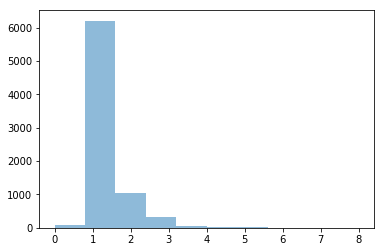

bedrooms


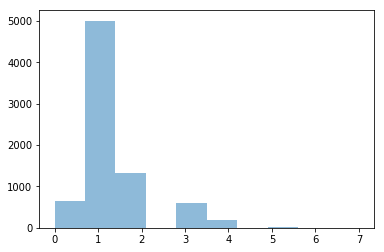

beds


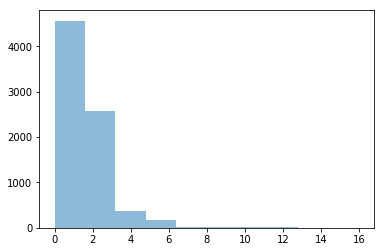

cleaning_fee


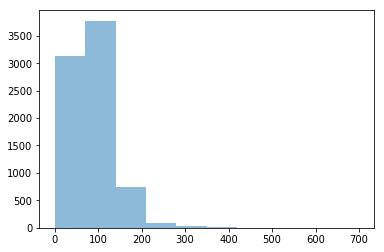

guests_included


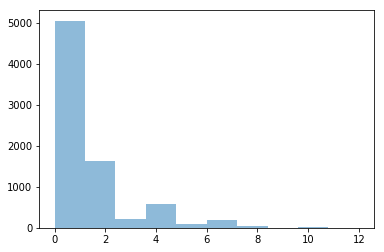

host_listings_count


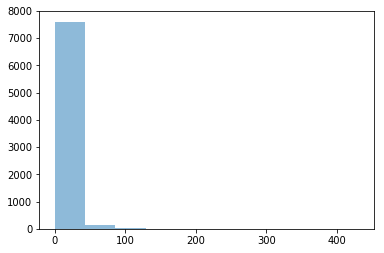

host_acceptance_rate


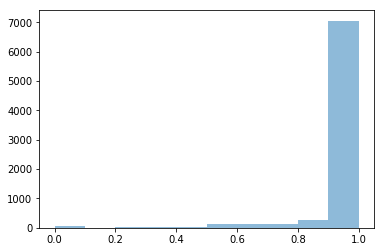

host_response_rate


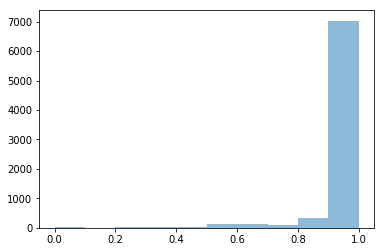

host_has_profile_pic


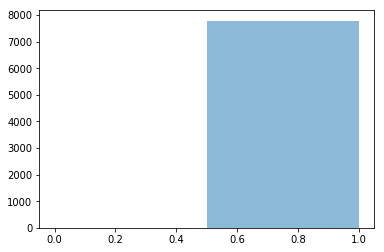

host_identity_verified


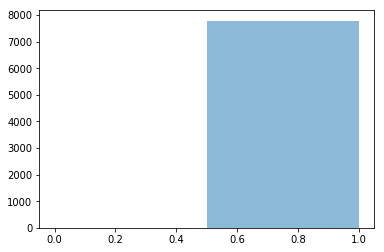

days_delta


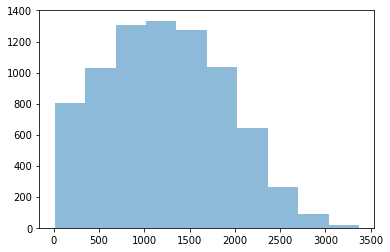

reviews_per_month


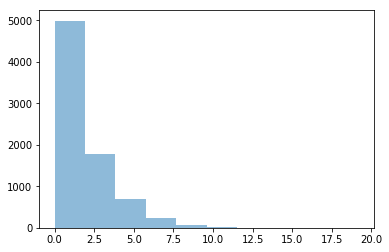

review_scores_rating


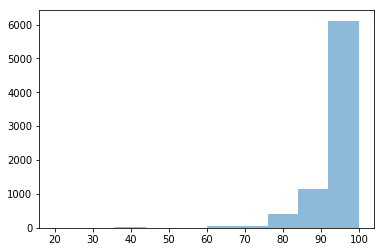

In [13]:
import matplotlib.pyplot as plt
for c in data.columns:
    if 'id' != c:
        print c
        lst = list(data[c].fillna(data[c].median()))
        
        b = 10
        if data[c].dtype == 'bool':
            b = 2
        plt.hist(lst, bins=b, alpha=0.5)
        plt.show()

(array([ 223.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        7570.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

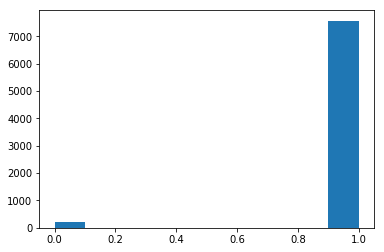

In [14]:
plt.hist(data['host_listings_count'] < 100)

# Scatter plot independent variable by each dependent variable

# Takeaways
1. Remove 'bathrooms' >= 5
2. Remove 'bedrooms' > 5
3. Remove 'beds' >= 8
4. Remove 'cleaning_fee' >= 400
5. Remove 'guests_included' > 8
6. Remove 'host_listings_count' > 100
7. Remove 'host_acceptance_rate' == 0.
8. Remove 'host_response_rate' == 0.
9. Remove 'reviews_per_month' > 12.
10. Drop 'host_has_profile_pic'
11. Drop 'host_identity_verified'

# Split data into Train and Test sets

Before preprocessing data, we need split it into Train and Test sets. Once split, we will impute missing values using Median. And finally, we will drop the outliers as mentioned in the Takeaways section. This sequence is important because we have a ton of missing values, and we'd be left with a tiny dataset if we dropped outliers before imputing missing values.

In [15]:
from sklearn.model_selection import train_test_split

Train, Test = train_test_split(data, test_size=0.33, random_state=1234)

print Train.shape
print Test.shape

(5221, 13)
(2572, 13)


# Impute missing values for Train and Test sets
We will use Median for imputing missing values because it is not as affected by outliers as the Mean.
We will train the Imputer on the training data, and use this to fill the values for both Train and Test sets. 
We will not train a new Imputer on test data. This is important because we do not want to look at the test data when imputing the values.

In [16]:
# Impute missing values using median for both independent and dependent variables
# We don't care for host_has_profile_pic, and host_identity_verified.
# We dropped missing values from our dependent variable earlier, 
# so it won't be affected by imputation here.

import numpy as np
from sklearn.preprocessing import Imputer

# We need the 
train_colnames = Train.columns
print train_colnames

# Train data first
# axis 0 means impute along columns
train_imp = Imputer(missing_values=np.nan, strategy='median', axis=0, copy=True)
train_imp.fit(Train)
Train = train_imp.transform(Train)


# Then Test data
test_colnames = Test.columns
print test_colnames
Test = train_imp.transform(Test)

print Train.shape
print Test.shape

Index([u'bathrooms', u'bedrooms', u'beds', u'cleaning_fee', u'guests_included',
       u'host_listings_count', u'host_acceptance_rate', u'host_response_rate',
       u'host_has_profile_pic', u'host_identity_verified', u'days_delta',
       u'reviews_per_month', u'review_scores_rating'],
      dtype='object')
Index([u'bathrooms', u'bedrooms', u'beds', u'cleaning_fee', u'guests_included',
       u'host_listings_count', u'host_acceptance_rate', u'host_response_rate',
       u'host_has_profile_pic', u'host_identity_verified', u'days_delta',
       u'reviews_per_month', u'review_scores_rating'],
      dtype='object')
(5221, 13)
(2572, 13)


# Handle Outliers
Drop them from Training data, as discussed in the Takeaways section.

In [17]:
# We need DataFrames here because we're lazy
Train = pd.DataFrame(Train, columns=train_colnames)
Train.sample()
Test = pd.DataFrame(Test, columns=test_colnames)
Test.sample()

def drop_outliers(t):
    # Drop outliers from dependent variable
    h = 0
    if 'review_scores_value' == dependent_variable:
        h = 3
    elif 'review_scores_rating' == dependent_variable:
        h = 80
    t = t.loc[t[dependent_variable] >= h]
    
    # Remove reviews_per_month == 0
    t = t.loc[t.reviews_per_month > 0].astype(float)

    # 1. Remove 'bathrooms' >= 5, convert to int
    t = t.loc[t.bathrooms < 5]
    t.bathrooms = t.bathrooms.astype(int)

    # 2. Remove 'bedrooms' > 5, convert to int
    t = t.loc[t.bedrooms <= 5]
    t.bedrooms = t.bedrooms.astype(int)

    # 3. Remove 'beds' >= 8, convert to int
    t = t.loc[t.beds < 8]
    t.beds = t.beds.astype(int)

    # 4. Remove 'cleaning_fee' > 400
    t = t.loc[t.cleaning_fee <= 400]

    # 5. Remove 'guests_included' > 8
    t = t.loc[t.guests_included <= 8]
    t = t.loc[t.guests_included > 0]
    t.guests_included = t.guests_included.astype(int)

    # 6. Remove 'host_listings_count' > 100
    t = t.loc[t.host_listings_count <= 100]
    # Remove'host_listings_count' <= 0
    t = t.loc[t.host_listings_count > 0]
    t.host_listings_count = t.host_listings_count.astype(int)
    
    

    # 7. Remove 'host_acceptance_rate' == 0.
    t = t.loc[t.host_acceptance_rate > 0.]

    # 8. Remove 'host_response_rate' == 0.
    t = t.loc[t.host_acceptance_rate > 0.]

    # 9. Remove 'reviews_per_month' > 12.
    t = t.loc[t.reviews_per_month <= 12]

    # 10. Drop 'host_has_profile_pic'
    t = t.drop('host_has_profile_pic', axis=1)

    # 11. Drop 'host_identity_verified'
    t = t.drop('host_identity_verified', axis=1)
    
    return t

Train = drop_outliers(Train)
# For Test, we will only drop the unneeded columns
# Test = Test.drop(['host_has_profile_pic', 'host_identity_verified'], axis=1)

Test = drop_outliers(Test)

print Train.shape
print Test.shape

(4918, 11)
(2414, 11)


# Create feature interactions

1. bathrooms x bedrooms
2. bedrooms x beds
3. beds x guests_included
4. bathrooms x guests_included
5. host_acceptance_rate x host_response_rate


In [18]:
def create_interaction(f1, f2, intyp):
    if 'D' == intype:
        return f1 / f2
    if 'A' == intype:
        return f1 + f2
    if 'S' == intype:
        return f1 - f2
    
    # Mulitply the features by default
    return f1 * f2

def get_interacted_dataset(ds, interactions_dict, drop=False):
    for k, v in interactions_dict.items():
        ds[k+'_by_'+v[0]] = ds[k] * ds[v[0]]
        
    if drop:
        for k in interactions_dict.keys():
            ds = ds.drop(k, axis=1)
    
    return ds


inter_dct = {
    'bedrooms': ('bathrooms', 'M'), 
    'bedrooms': ('beds', 'M'), 
    'beds': ('guests_included', 'M'), 
    'bathrooms': ('guests_included', 'M'), 
    'cleaning_fee': ('guests_included', 'D'), 
    'host_acceptance_rate': ('host_response_rate', 'D')
}

Train = get_interacted_dataset(Train, inter_dct, drop=True)
Test = get_interacted_dataset(Test, inter_dct, drop=True)

# Square the reviews_per_month after adding 1 to each observation

In [19]:
# Train['reviews_per_month'] = (Train['reviews_per_month'] + 1)**2
# Test['reviews_per_month'] = (Test['reviews_per_month'] + 1)**2

In [20]:
new_dep_var = dependent_variable

# Interact Dependent Variable with 'reviews_per_month'

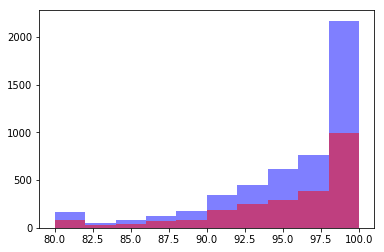

In [21]:
plt.hist(Train[new_dep_var], alpha=0.5, color='b')
plt.hist(Test[new_dep_var], alpha=0.5, color='r')
plt.show()

# Separate the Dependent and Independet Variables

In [22]:
# Train data
y_train = Train[new_dep_var].values
print y_train.shape

X_train = Train.drop([dependent_variable, new_dep_var], axis=1)
print X_train.shape

# Test data
y_test = Test[new_dep_var].values
print y_test.shape

X_test = Test.drop([dependent_variable, new_dep_var], axis=1)
print X_test.shape

(4918,)
(4918, 10)
(2414,)
(2414, 10)


In [23]:
for c in sorted(X_train.columns):
    print c

bathrooms_by_guests_included
bedrooms_by_beds
beds_by_guests_included
cleaning_fee_by_guests_included
days_delta
guests_included
host_acceptance_rate_by_host_response_rate
host_listings_count
host_response_rate
reviews_per_month


# Normalize the Training and Test Data

In [24]:
def normalize_df(df):
    return (df - df.min()) / (df.max() - df.min())

# X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())

X_train = normalize_df(X_train)
X_test = normalize_df(X_test)

# Scale the Dependent variables
We don't want any one variable dominating others in the regression model, so let's start by scaling the dependent variables. As with Imputation, we will train the scaler only on the training data (to learn the mean and standard deviation), and then use it as-is on the Test data. We will assume that all dependent variables are interval.

In [25]:
# Scale the data

from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer(output_distribution='normal') # output distribution: 'uniform', or 'normal'
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

0: -5.199337582605575, -5.199337582605575


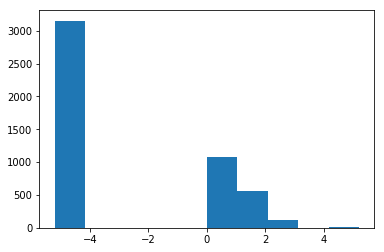

1: -5.199337582605575, -5.199337582605575


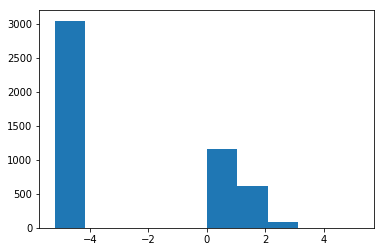

2: -5.199337582605575, -5.199337582605575


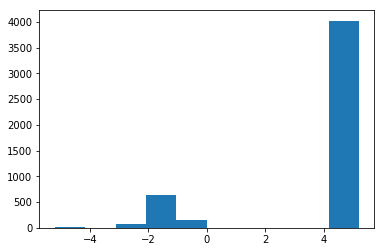

3: -5.199337582605575, -5.199337582605575


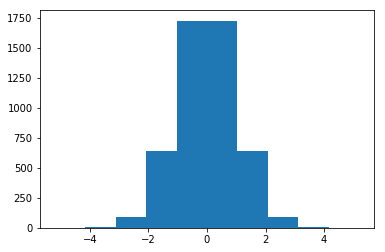

4: -5.199337582605575, -5.199337582605575


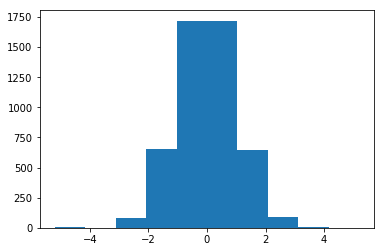

5: -5.199337582605575, -5.199337582605575


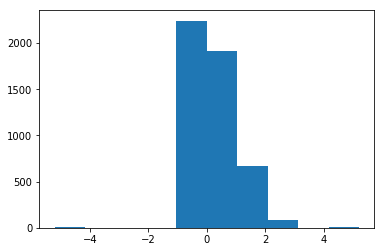

6: -5.199337582605575, -5.199337582605575


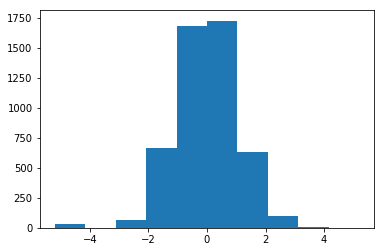

7: -5.199337582605575, -5.199337582605575


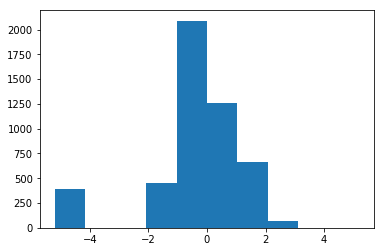

8: -5.199337582605575, -5.199337582605575


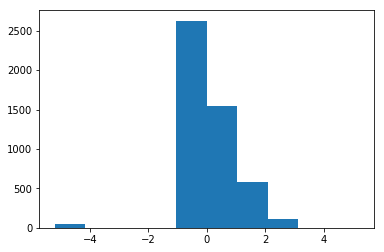

9: -5.199337582605575, -5.199337582605575


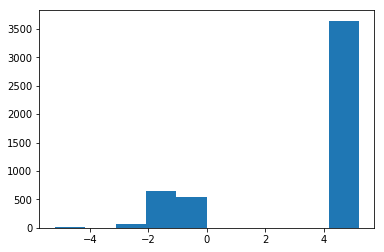

In [26]:
import matplotlib.pyplot as plt
for i in range(X_train.shape[1]):
    print '%s: %s, %s' % (i, np.min(X_train[:, i]), np.min(X_train[:, i]))
    plt.hist(X_train[:, i])
    plt.show()

# Try some transformations on the Independent Variables

exp


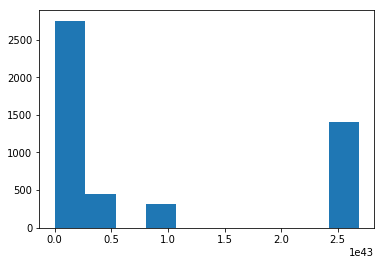

identity


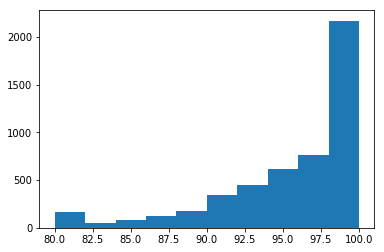

log


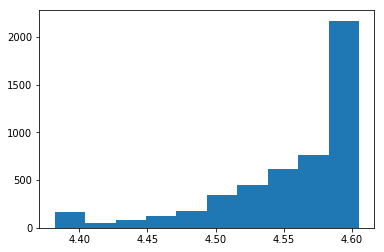

sqrt


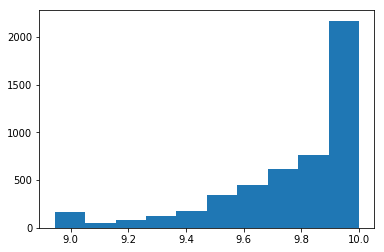

standard_scale


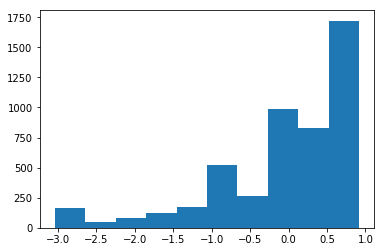

x^1/4


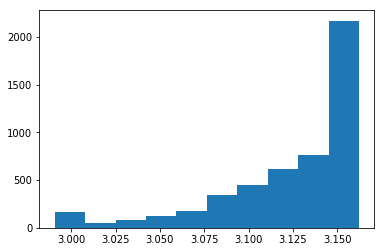

In [27]:
func_dict = {
    'identity': lambda x: x, 
    'sqrt': np.sqrt, 
    'log': np.log, 
    'exp': np.exp, 
    'x^1/4': lambda x: [i**(1./4) for i in x],
    'standard_scale': lambda x: [(i - np.mean(x)) / np.std(x) for i in x],
}

for k in sorted(func_dict.keys()):
    print k
    plt.hist(func_dict[k](y_train.ravel()))
    plt.show()


# Create a baseline model using Training Mean

Mean squared error: 26.31
Variance score: -0.00


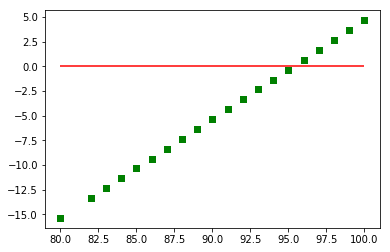

In [28]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, make_scorer, roc_auc_score


m_train = np.mean(y_train)
y_test_baseline_pred = np.array([m_train for i in range(y_test.shape[0])])


# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test.ravel(), y_test_baseline_pred.ravel()))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test.ravel(), y_test_baseline_pred.ravel()))

# Plot the residuals

plt.scatter(y_test, y_test-y_test_baseline_pred, c='g', marker='s', alpha=0.5)
plt.hlines(y=0, xmin=np.min(y_test), xmax=np.max(y_test), color='r')
plt.show()

# Create a baseline model using Training Median

Mean squared error: 29.94
Variance score: -0.14


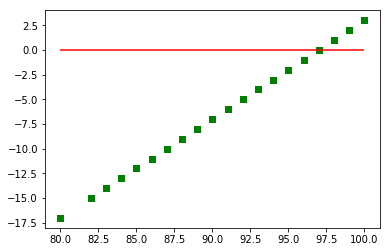

In [29]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, make_scorer, roc_auc_score


m_train = np.median(y_train)
y_test_baseline_pred = np.array([m_train for i in range(y_test.shape[0])])


# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test.ravel(), y_test_baseline_pred.ravel()))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test.ravel(), y_test_baseline_pred.ravel()))

# Plot the residuals

plt.scatter(y_test, y_test-y_test_baseline_pred, c='g', marker='s', alpha=0.5)
plt.hlines(y=0, xmin=np.min(y_test), xmax=np.max(y_test), color='r')
plt.show()

Mean squared error: 25.13
Variance score: 0.04
train residuals:


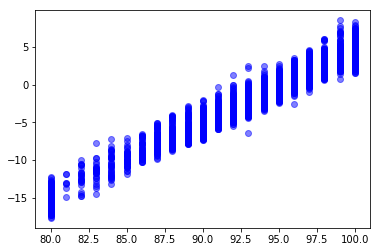

test residuals:


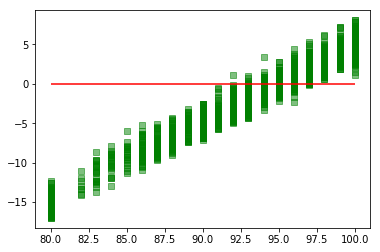

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model

# Create linear regression object
regr = linear_model.Lasso(alpha=0.001, fit_intercept=True, max_iter=10000)

# Train the model using the training sets
regr.fit(X_train, y_train)

y_train_pred = regr.predict(X_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test.ravel(), y_pred.ravel()))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test.ravel(), y_pred.ravel()))

# Plot the residuals
print 'train residuals:'
plt.scatter(y_train, y_train-y_train_pred, c='b', marker='o', alpha=0.5)
plt.show()

print 'test residuals:'
plt.scatter(y_test, y_test-y_pred, c='g', marker='s', alpha=0.5)
plt.hlines(y=0, xmin=np.min(y_test), xmax=np.max(y_test), color='r')
plt.show()

# Check for endogeneity

guests_included: correlation coef: 6.783827708810791e-05


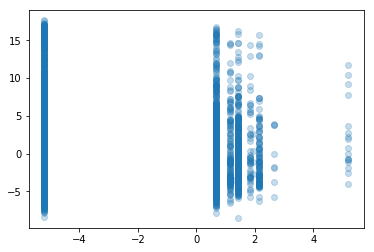

host_listings_count: correlation coef: 6.70110162307618e-05


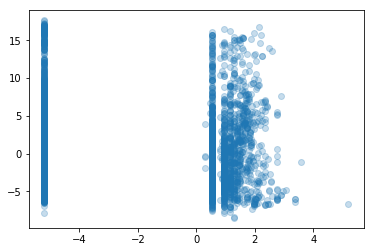

host_response_rate: correlation coef: -7.824765343044147e-05


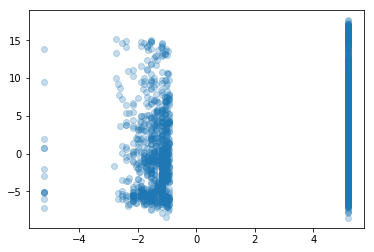

days_delta: correlation coef: -0.0002022993186276267


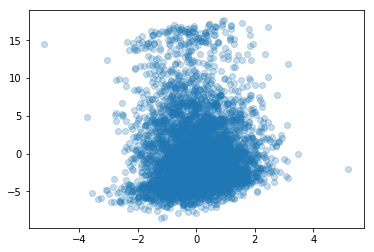

reviews_per_month: correlation coef: 0.0002005342581806735


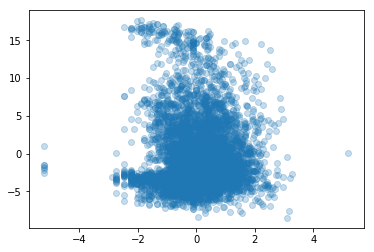

review_scores_rating: correlation coef: 0.00023056390363894265


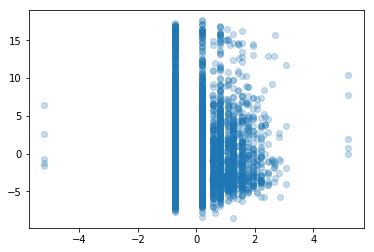

beds_by_guests_included: correlation coef: -0.00019020117381281928


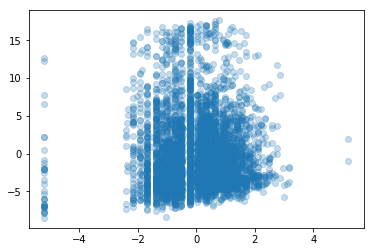

cleaning_fee_by_guests_included: correlation coef: -0.00012148845312457512


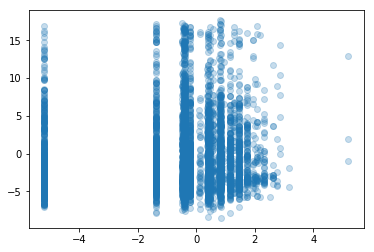

bedrooms_by_beds: correlation coef: -0.00020774144634201752


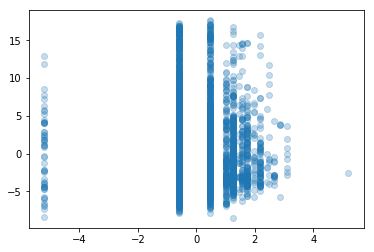

bathrooms_by_guests_included: correlation coef: -7.123931360427483e-05


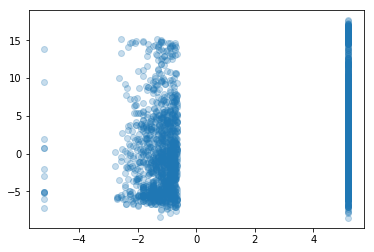

In [31]:
y_train_error = regr.predict(X_train) - y_train
for cname, c in zip(Train.columns, X_train.T):
    print '%s: correlation coef: %s' % (cname, np.corrcoef(c.ravel(), y_train_error.ravel())[1, 0])
    plt.scatter(c.ravel(), y_train_error.ravel(), alpha=0.25)
    plt.show()

In [32]:
from sklearn import model_selection

from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR


kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=1234)


def build_model(model_name):
    return model_name()

for model_name in [LinearRegression, Ridge, ElasticNet, \
                   AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor]:
    
    model = build_model(model_name)
    results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    print model_name, results.mean()
    

<class 'sklearn.linear_model.base.LinearRegression'> -24.352229475815705
<class 'sklearn.linear_model.ridge.Ridge'> -24.352194277467618
<class 'sklearn.linear_model.coordinate_descent.ElasticNet'> -24.879297715938698
<class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'> -25.968212786023116
<class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'> -23.698035254042065
<class 'sklearn.ensemble.forest.RandomForestRegressor'> -26.269632573311476


Mean squared error: 25.66
r2 score: 0.02
explained variance score: 0.05


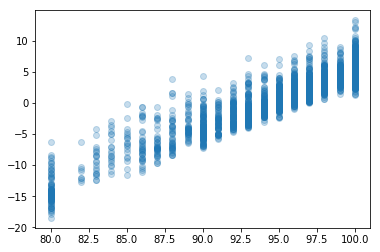

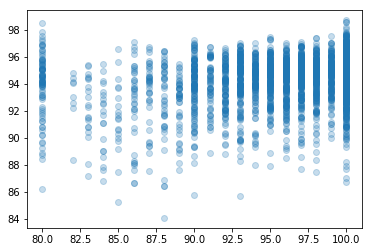

In [33]:
import xgboost
from sklearn.metrics import explained_variance_score

xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.05, gamma=0, 
                          subsample=0.5, colsample_bytree=0.5, max_depth=15, 
                          objective='reg:linear')

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('r2 score: %.2f' % r2_score(y_test.ravel(), y_pred.ravel(),))

# Explained variance score: 1 is perfect prediction
print('explained variance score: %.2f' % explained_variance_score(y_test.ravel(), y_pred.ravel()))   
plt.scatter(y_test.tolist(), (y_test-y_pred).tolist(), alpha=0.25)
plt.show()

plt.scatter(y_test, y_pred, alpha=0.25)
plt.show()

Mean squared error: 24.40
r2 score: 0.07
explained variance score: 0.07


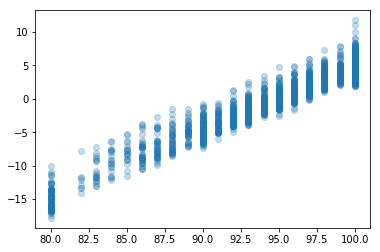

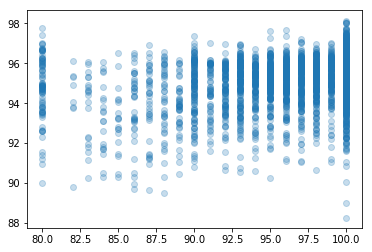

In [34]:
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.01, subsample=0.75, max_depth=15)

gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('r2 score: %.2f' % r2_score(y_test.ravel(), y_pred.ravel(),))

# Explained variance score: 1 is perfect prediction
print('explained variance score: %.2f' % explained_variance_score(y_test.ravel(), y_pred.ravel()))   
plt.scatter(y_test.tolist(), (y_test-y_pred).tolist(), alpha=0.25)
plt.show()

plt.scatter(y_test, y_pred, alpha=0.25)
plt.show()

# Grid Search over GradientBoostingRegressor

# Grid Search Done

# Stack some Models using StackingRegressor

## Create a model list first

In [35]:
lass = linear_model.Lasso(alpha=0.001, fit_intercept=False, 
                          max_iter=10000)

ridge = linear_model.Ridge(normalize=False, alpha=0.1, 
                           max_iter=10000)

gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.01, 
                               subsample=0.75, max_depth=15)

xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.05, 
                           gamma=0, subsample=0.5, colsample_bytree=0.5, 
                           max_depth=15, objective='reg:linear')

randf = RandomForestRegressor(n_estimators=100, min_samples_split=10)

svr_rbf = SVR(kernel='rbf')

## Let's try vecstack API

task:         [regression]
metric:       [rmse]
variant:      [A]
n_estimators: [4]

estimator  0: [lr: LinearRegression]
    fold  0:  [25.02272394]
    fold  1:  [20.90313738]
    fold  2:  [20.98893052]
    fold  3:  [27.43195650]
    fold  4:  [25.53671681]
    fold  5:  [24.43334758]
    fold  6:  [22.54799270]
    fold  7:  [22.75365234]
    fold  8:  [26.90468006]
    fold  9:  [26.95647711]
    ----
    MEAN:     [24.34796149] + [2.31645278]

estimator  1: [ridge: Ridge]
    fold  0:  [25.02272402]
    fold  1:  [20.90313743]
    fold  2:  [20.98893051]
    fold  3:  [27.43195616]
    fold  4:  [25.53671678]
    fold  5:  [24.43334765]
    fold  6:  [22.54799264]
    fold  7:  [22.75365240]
    fold  8:  [26.90467999]
    fold  9:  [26.95647698]
    ----
    MEAN:     [24.34796146] + [2.31645271]

estimator  2: [gbf: GradientBoostingRegressor]
    fold  0:  [24.37048537]
    fold  1:  [19.20298097]
    fold  2:  [20.06476772]
    fold  3:  [26.03019846]
    fold  4:  [25.342425

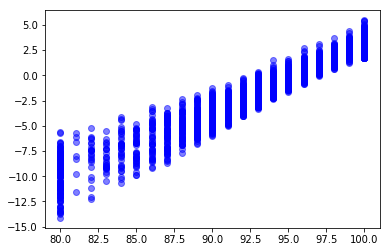

test residuals:


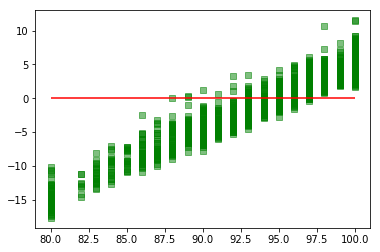

In [36]:
from vecstack import StackingTransformer
from vecstack import stacking
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR

def rmse(train, pred):
    return mean_squared_error(train, pred)


def rsq(train, pred):
    return r2_score(train, pred)

lr = linear_model.LinearRegression()

lass = linear_model.Lasso(alpha=0.001, fit_intercept=False, 
                          max_iter=10000)

ridge = linear_model.Ridge(normalize=False, alpha=0.001, 
                           max_iter=10000)

gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.01, 
                               subsample=0.75, max_depth=15)

xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.05, 
                           gamma=0, subsample=0.5, colsample_bytree=0.5, 
                           max_depth=15, objective='reg:linear', reg_alpha=100, n_jobs=-1)

randf = RandomForestRegressor(n_estimators=100, min_samples_split=10, n_jobs=-1)

svr_rbf = SVR(kernel='rbf')


estimators = [('lr', lr), 
              # ('lass', lass), 
              ('ridge', ridge),
              ('gbf', GradientBoostingRegressor(alpha=0.9)), 
              # ('abr', AdaBoostRegressor(learning_rate=0.001)),
              # ('xgb', xgb), 
              ('randf', randf), 
             ]

stack = StackingTransformer(estimators, regression=True, 
                            shuffle=True, n_folds=10, 
                            metric=rmse, verbose=2, 
                           )

stack = stack.fit(X_train, y_train)

# Get stacked features
S_train = stack.transform(X_train)
S_test = stack.transform(X_test)

# Use 2nd level estimator on Stacked data
# model = RandomForestRegressor(n_estimators=100, min_impurity_decrease=0.05)
model = gb

model.fit(S_train, y_train)

y_train_pred = model.predict(S_train)

# Make predictions using the testing set
y_pred = model.predict(S_test)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test.ravel(), y_pred.ravel()))
# Explained variance score: 1 is perfect prediction
print 'Variance score: %.2f' % r2_score(y_test.ravel(), y_pred.ravel()) 

# Plot the residuals
print 'train residuals:'
plt.scatter(y_train, y_train-y_train_pred, c='b', marker='o', alpha=0.5)
plt.show()

print 'test residuals:'
plt.scatter(y_test, y_test-y_pred, c='g', marker='s', alpha=0.5)
plt.hlines(y=0, xmin=np.min(y_test), xmax=np.max(y_test), color='r')
plt.show()

Results for train
train Mean Squared Error: 22.0319
train R-Squared: 0.1369


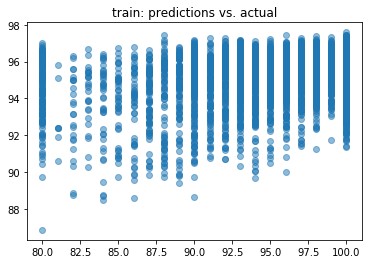

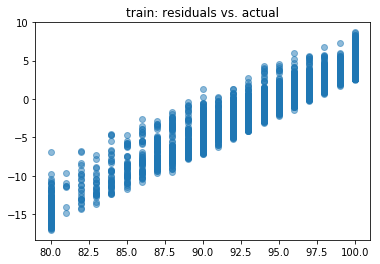

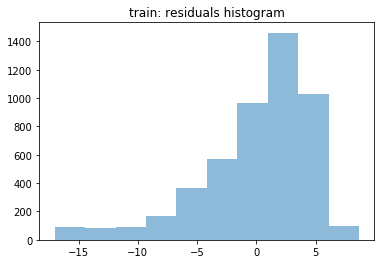

Results for test
test Mean Squared Error: 24.5880
test R-Squared: 0.0625


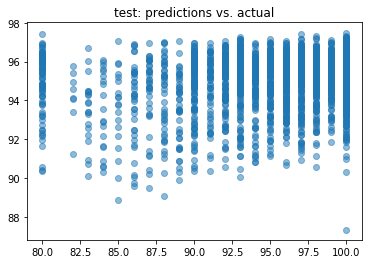

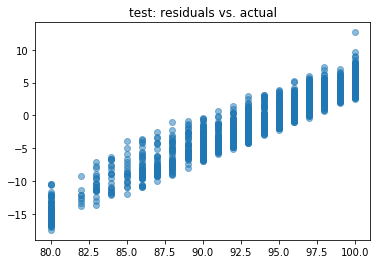

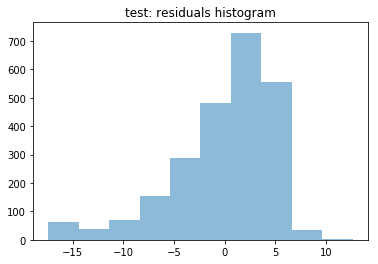

In [37]:
import xgboost
from sklearn.metrics import explained_variance_score

xgb = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.05, gamma=0, 
                          subsample=0.5, colsample_bytree=0.5, max_depth=50, 
                          objective='reg:linear', reg_alpha=100)

# print y_train.reshape(-1, 1).shape

# print len(y_train.shape)

result = run_prediction(X_train, y_train, X_test, y_test, xgb)

In [38]:
randf = RandomForestRegressor(
                              min_samples_split=100, 
                              min_impurity_decrease=0.01, 
                              min_samples_leaf =0.05, 
                              max_features = 0.5, 
                              n_jobs=-1, 
                              verbose=0)

/Users/jhabib/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Results for train
train Mean Squared Error: 23.9770
train R-Squared: 0.0607


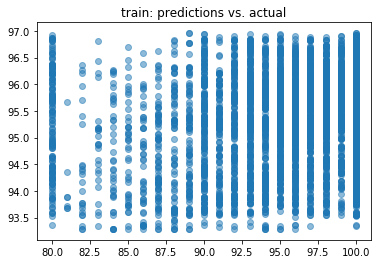

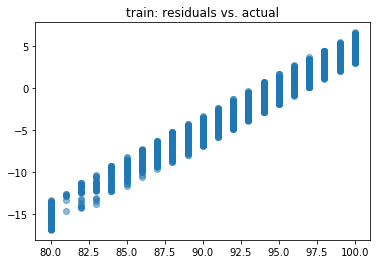

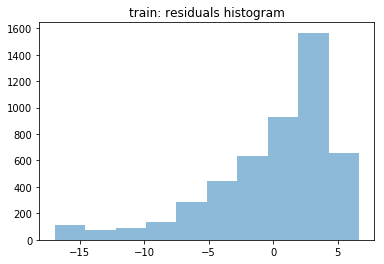

Results for test
test Mean Squared Error: 25.2997
test R-Squared: 0.0353


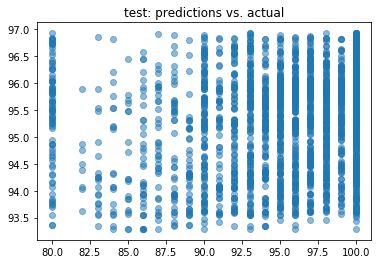

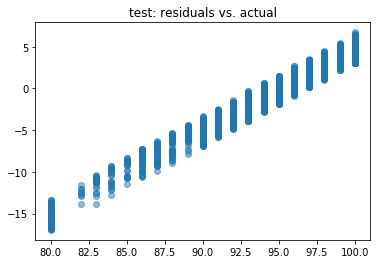

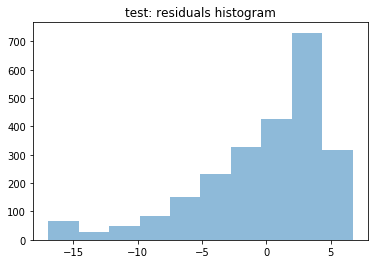

{'test': {'pred': array([95.95313509, 96.60405537, 95.20732695, ..., 95.34968902,
       95.59568677, 96.67775142]), 'mse': 25.29968281303361, 'r2': 0.03534942828807164}, 'train': {'pred': array([95.4845603 , 94.07930439, 95.92599275, ..., 93.76826015,
       95.99757458, 96.53906335]), 'mse': 23.97702058577116, 'r2': 0.06070049758428886}}


In [39]:
result = run_prediction(X_train, y_train, X_test, y_test, randf)
print result

# Try Blending

# Try Tensorflow

In [40]:
import tensorflow as tf

print X_train.shape
print y_train.shape

W = tf.Variable(tf.truncated_normal([10, 1], mean=0., stddev=1.0, dtype=tf.float64))
b = tf.Variable(tf.zeros(1, dtype=tf.float64))


(4918, 10)
(4918,)


In [41]:
def calc(X, y):
    preds = tf.add(b, tf.matmul(X, W))
    err = tf.reduce_mean(tf.square(y - preds))
    
    return preds, err

In [42]:
p, cost = calc(X_train, y_train)
learning_rate = 0.01
epochs = 500
points = [[], []]

In [43]:
init = tf.global_variables_initializer()
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

epoch: 0
2076.317591986927
epoch: 100
623.5108008860688
epoch: 200
371.0025628757789
epoch: 300
242.26214962175638
epoch: 400
165.02235800567158


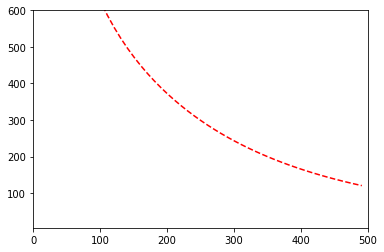

Validation score: 116.88125560018578
Test score: 122.90827570118637


In [44]:
with tf.Session() as sess:
    sess.run(init)
    
    for i in list(range(epochs)):
        
        sess.run(optimizer)
        
        if i % 10 == 0.:
            points[0].append(i+1)
            points[1].append(sess.run(cost))
        
        if i % 100 == 0:
            print 'epoch: %s' % i            
            print sess.run(cost)
        
    
    plt.plot(points[0], points[1], 'r--')
    plt.axis([0, epochs, 5, 600])
    plt.show()
    
    valid_cost = calc(X_train, y_train)[1]
    print 'Validation score: %s' % sess.run(valid_cost)
    test_cost = calc(X_test, y_test)[1]
    print 'Test score: %s' % sess.run(test_cost)

In [54]:
from sklearn.model_selection import KFold
from skgarden import RandomForestQuantileRegressor

kf = KFold(n_splits=5, random_state=1234)
rfqr = RandomForestQuantileRegressor(random_state=1234, 
                                    min_samples_split=10, 
                                    n_estimators=1000)
y_true_all = []
lower = []
upper = []


for train_index, test_index in kf.split(X_train):
    Xtrn = X_train[train_index]
    ytrn = y_train[train_index]
    Xtst = X_train[test_index]
    ytst = y_train[test_index]
    
    rfqr.set_params(max_features=Xtrn.shape[1] // 3)
    rfqr.fit(Xtrn, ytrn)
    y_true_all = np.concatenate((y_true_all, ytst))
    upper = np.concatenate((upper, rfqr.predict(Xtst, quantile=98.5)))
    lower = np.concatenate((lower, rfqr.predict(Xtst, quantile=2.5)))
    
interval = upper - lower
sort_ind = np.argsort(interval)
y_true_all = y_true_all[sort_ind]
upper = upper[sort_ind]
lower = lower[sort_ind]
mean = (upper + lower) / 2

y_true_all -= mean
upper -= mean
lower -= mean

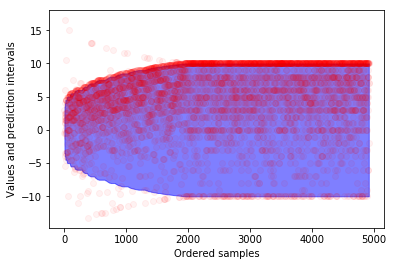

In [68]:
plt.plot(y_true_all, 'ro', alpha=0.05, color='r')
plt.fill_between(
np.arange(len(upper)), lower, upper, 
    alpha=0.5, color='b', 
    label='Pred. interval')

plt.xlabel('Ordered samples')
plt.ylabel('Values and prediction intervals')
plt.show()

In [56]:
mean_squared_error(y_test, rfqr.predict(X_test))

24.359890451284496

In [69]:
r2_score(y_test, rfqr.predict(X_test))

0.07118273282992738

(array([ 29.,  47.,  39.,  86., 170., 302., 493., 712., 487.,  49.]),
 array([-18.46224933, -15.6506042 , -12.83895908, -10.02731396,
         -7.21566884,  -4.40402371,  -1.59237859,   1.21926653,
          4.03091165,   6.84255678,   9.6542019 ]),
 <a list of 10 Patch objects>)

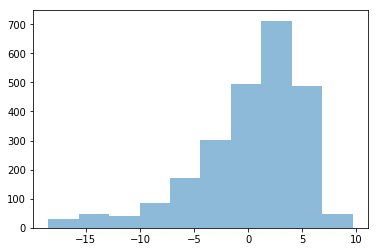

In [70]:
plt.hist(y_test - rfqr.predict(X_test), alpha=0.5)

# Try Keras